## Extractive Summarization - Pytorch

In this notebook, we provide an implementation for training an extractive text summarization model. The overall goal is to "score" each sentence in a passage where the score represents the likelihood that the sentence belongs in a summary.


## Dataset

We will use the CNN/Dailymail dataset (contains articles and human written highlights) which has been preprocessed in the following way

- Each sentence in each article (extracted using a large Spacy LM) is assigned a label (0: not in summary, 1: in summary). Since CNN/DailyMail highlights dont contain exact extracts, the label is generatedd based on max Rogue score between sentence and each sentence in highlights. See data preprocesssing notebook for details.
- Data is undersampled to reduce class imbalance

## Problem Formulation and Model

We treat this as a sentence classification problem where the goal is to classify each sentence in a document as belonging to a summary or not, given the document (or portions of the document)

- Model Input: a sentence, and the entire document
- Model Output: A score representing likelihood of belonging in the summary or not.

## Implementation

- We use sentence bert models to get representations for our text. We use the smallest model (sentence-transformers/paraphrase-MiniLM-L3-v2), but this can be replaced by a larger more accurate model. See the list of sentence bert pretrained  [models](https://www.sbert.net/docs/pretrained_models.html#sentence-embedding-models).
- Representations for sentence and document are concatenated and fed to a Dense layer and then predictions.

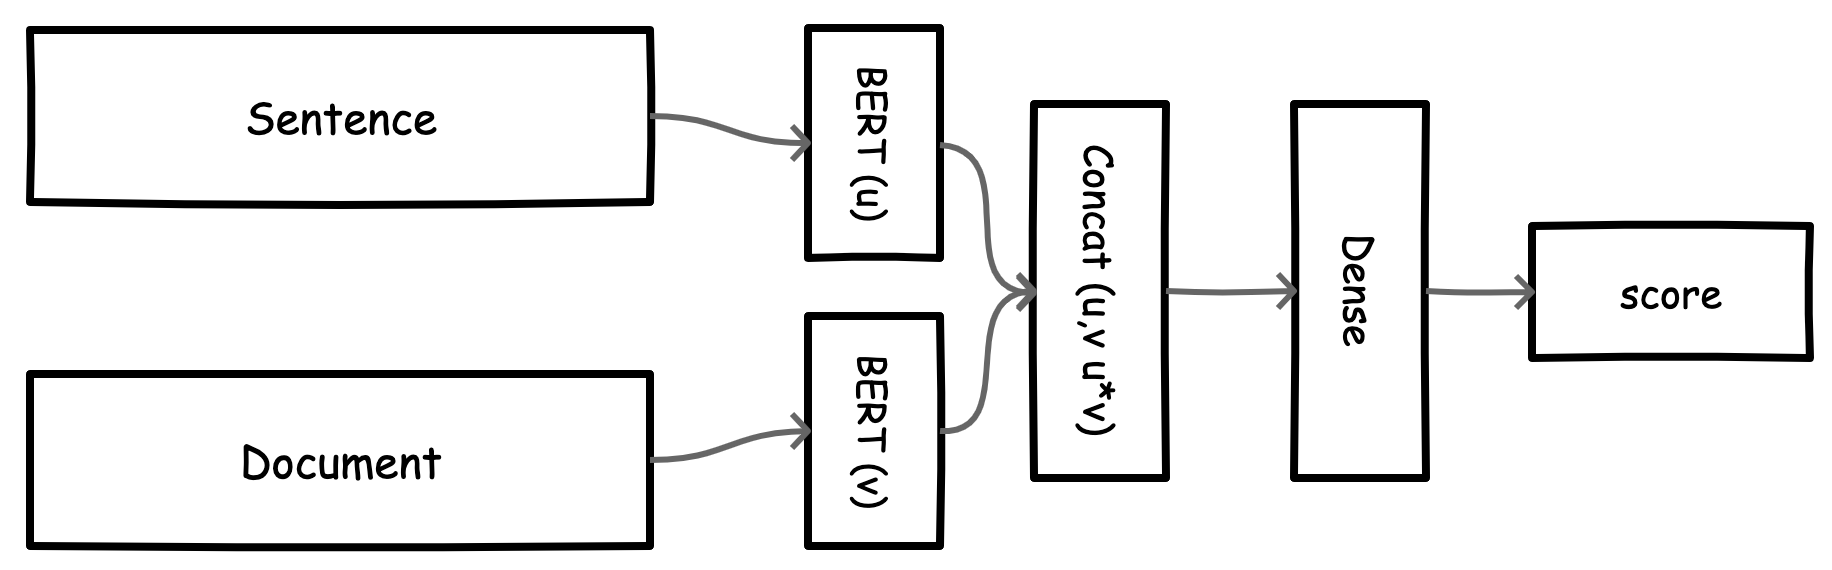

In [ ]:
!pip install -q transformers  rouge-score

  Preparing metadata (setup.py) ... done


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import pandas as pd
import transformers
from torch.utils.data import Dataset, DataLoader


from transformers import AutoTokenizer, AutoModel
sentenc_model_name = "sentence-transformers/paraphrase-MiniLM-L3-v2"
tokenizer = AutoTokenizer.from_pretrained(sentenc_model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import os

sum_dir = "drive/MyDrive/mlexperiments/extractivesummarization/" # location to store and load models

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the path to the CSV file
csv_file_path = "/content/test.csv"

# Load the dataset into a pandas DataFrame
try:
    df = pd.read_csv(csv_file_path)
    print("CSV file loaded successfully.")
except FileNotFoundError:
    print(f"File not found: {csv_file_path}")
    df = pd.DataFrame()  # Create an empty DataFrame if the file is not found

# Display the shape of the dataset
print("Original dataset shape:", df.shape)

# Check the contents of the dataset
print(df.head())

# Split the dataset into training and testing sets
if not df.empty:
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    # Display the shapes of the training and testing sets
    print("Training set shape:", train_df.shape)
    print("Testing set shape:", test_df.shape)
else:
    print("The dataset is empty or not loaded correctly.")


CSV file loaded successfully.
Original dataset shape: (11490, 3)
                                         id  \
0  92c514c913c0bdfe25341af9fd72b29db544099b   
1  2003841c7dc0e7c5b1a248f9cd536d727f27a45a   
2  91b7d2311527f5c2b63a65ca98d21d9c92485149   
3  caabf9cbdf96eb1410295a673e953d304391bfbb   
4  3da746a7d9afcaa659088c8366ef6347fe6b53ea   

                                             article  \
0  Ever noticed how plane seats appear to be gett...   
1  A drunk teenage boy had to be rescued by secur...   
2  Dougie Freedman is on the verge of agreeing a ...   
3  Liverpool target Neto is also wanted by PSG an...   
4  Bruce Jenner will break his silence in a two-h...   

                                          highlights  
0  Experts question if  packed out planes are put...  
1  Drunk teenage boy climbed into lion enclosure ...  
2  Nottingham Forest are close to extending Dougi...  
3  Fiorentina goalkeeper Neto has been linked wit...  
4  Tell-all interview with the reality T

## Create a Data Loader Class

- Create a dataloader class that yields sentences and documentss and labels.

In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

class CNNDailyMailData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        article = str(self.data.iloc[index].article)
        article = " ".join(article.split())

        highlights = str(self.data.iloc[index].highlights)
        highlights = " ".join(highlights.split())

        inputs = self.tokenizer.batch_encode_plus(
            [article],
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        target_inputs = self.tokenizer.batch_encode_plus(
            [highlights],
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        article_ids = inputs['input_ids']
        article_mask = inputs['attention_mask']

        highlights_ids = target_inputs['input_ids']
        highlights_mask = target_inputs['attention_mask']

        return {
            'article_ids': torch.tensor(article_ids[0], dtype=torch.long),
            'highlights_ids': torch.tensor(highlights_ids[0], dtype=torch.long),
            'article_mask': torch.tensor(article_mask[0], dtype=torch.long),
            'highlights_mask': torch.tensor(highlights_mask[0], dtype=torch.long),
        }

    def __len__(self):
        return self.len


## Build Model

- Build model based on sentence Bert pretrained models.

In [ ]:
import torch

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


In [ ]:
class SentenceBertClass(nn.Module):
    def __init__(self, model_name="sentence-transformers/paraphrase-MiniLM-L3-v2", in_features=384):
        super(SentenceBertClass, self).__init__()
        self.l1 = AutoModel.from_pretrained(model_name)
        self.pre_classifier = nn.Linear(in_features * 2, 768)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(768, 1)
        self.classifierSigmoid = nn.Sigmoid()

    def forward(self, article_ids, highlights_ids, article_mask, highlights_mask):
        article_output = self.l1(input_ids=article_ids, attention_mask=article_mask)
        highlights_output = self.l1(input_ids=highlights_ids, attention_mask=highlights_mask)

        article_embeddings = mean_pooling(article_output, article_mask)
        highlights_embeddings = mean_pooling(highlights_output, highlights_mask)

        # Concatenate the embeddings
        concat_features = torch.cat((article_embeddings, highlights_embeddings), dim=1)

        pooler = self.pre_classifier(concat_features)
        pooler = nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.classifierSigmoid(output)

        return output

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AdamW
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import time
import cProfile
import torch.nn as nn

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len_input):
        self.data = dataframe
        self.articles = self.data['article']
        self.highlights = self.data['highlights']
        self.tokenizer = tokenizer
        self.max_len_input = max_len_input

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        article = self.articles[idx]
        highlights = self.highlights[idx]

        input_encoding = self.tokenizer.encode_plus(
            article,
            add_special_tokens=True,
            max_length=self.max_len_input,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': input_encoding['input_ids'].flatten(),
            'attention_mask': input_encoding['attention_mask'].flatten(),
            'highlights': highlights
        }

# Corrected file paths
train_file = "/content/output.csv.txttrain_bdf.csv"
test_file = "/content/output.csv.txttest_bdf.csv"

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

# Reset indices
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# Constants
TRAIN_BATCH_SIZE = 4  # Reduce batch size to avoid memory issues
EPOCHS = 3
LEARNING_RATE = 2e-5
MAX_LEN_INPUT = 256
MODEL_NAME = 'sentence-transformers/paraphrase-MiniLM-L3-v2'
GRADIENT_ACCUMULATION_STEPS = 4

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Define CustomDataset and DataLoader
train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN_INPUT)
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

# Verify DataLoader
data_iter = iter(train_loader)
batch = next(data_iter)
print(batch)

# Define the model
model = AutoModel.from_pretrained(MODEL_NAME)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scaler = GradScaler()
criterion = nn.MSELoss()  # Using MSELoss as a placeholder

# Define train function
def train(epoch):
    model.train()
    tr_loss = 0
    nb_tr_steps = 0
    start_time = time.time()

    for step, data in enumerate(tqdm(train_loader, 0)):
        input_ids = data['input_ids'].to(device, dtype=torch.long)
        attention_mask = data['attention_mask'].to(device, dtype=torch.long)
        highlights = data['highlights']

        optimizer.zero_grad()

        with autocast():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # Get the sentence embeddings
            sentence_embeddings = outputs.last_hidden_state.mean(dim=1)

            # Dummy targets for demonstration purposes
            dummy_targets = torch.randn_like(sentence_embeddings).to(device)
            loss = criterion(sentence_embeddings, dummy_targets)

        scaler.scale(loss).backward()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()

        tr_loss += loss.item() * GRADIENT_ACCUMULATION_STEPS
        nb_tr_steps += 1

        if step % 100 == 0:
            elapsed_time = time.time() - start_time
            print(f"Step {step}, Loss: {tr_loss / nb_tr_steps}, Elapsed Time: {elapsed_time:.2f}s")
            start_time = time.time()

    print(f'Epoch {epoch}, Loss: {tr_loss / nb_tr_steps}')

# Profile the training function
cProfile.run('train(0)', sort='cumtime')

# Train the model
for epoch in range(EPOCHS):
    train(epoch)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'input_ids': tensor([[  101,  2074,  2420,  ...,  1012,  1045,   102],
        [  101,  2048,  2329,  ..., 25082,  2076,   102],
        [  101,  9274,  2071,  ...,  4286,  1011,   102],
        [  101,  2087,  2111,  ...,  2000,  8572,   102]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), 'highlights': ['Scott Turner Schofield has landed a role on the popular soap opera The Bold and the Beautiful .\nSchofield is now the first transgender male to score a major role on a daytime television show .\nHe will make his first appearance on May 8 .\nSchofield is a speaker and author known for his one-person shows that address transgender issues .', "Pair named as Jamie Richardson and Daniel Taylor from West Sussex .\nThey are fined $3,000 each, but say they only have $700 between them .\nIf fine cannot be paid, two men face jail terms of four months respectively .\nBoeing 787-8  was

model.safetensors:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/2298 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 1/2298 [00:01<56:50,  1.48s/it]

Step 0, Loss: 4.163829326629639, Elapsed Time: 1.49s


  5%|▍         | 107/2298 [00:05<01:10, 30.88it/s]

Step 100, Loss: 4.055525201382023, Elapsed Time: 3.34s


  9%|▉         | 204/2298 [00:08<01:14, 28.19it/s]

Step 200, Loss: 4.02651179726444, Elapsed Time: 3.31s


 13%|█▎        | 304/2298 [00:12<01:46, 18.75it/s]

Step 300, Loss: 4.032703455896472, Elapsed Time: 4.21s


 18%|█▊        | 403/2298 [00:17<01:34, 19.95it/s]

Step 400, Loss: 4.029669481025373, Elapsed Time: 5.28s


 22%|██▏       | 504/2298 [00:21<01:00, 29.68it/s]

Step 500, Loss: 4.028561223290875, Elapsed Time: 4.20s


 26%|██▋       | 604/2298 [00:25<00:55, 30.45it/s]

Step 600, Loss: 4.03030656300448, Elapsed Time: 3.23s


 31%|███       | 704/2298 [00:28<00:51, 31.23it/s]

Step 700, Loss: 4.0301675810113275, Elapsed Time: 3.22s


 35%|███▍      | 804/2298 [00:32<01:16, 19.62it/s]

Step 800, Loss: 4.028595631786351, Elapsed Time: 4.08s


 39%|███▉      | 904/2298 [00:37<01:13, 18.84it/s]

Step 900, Loss: 4.02538654859799, Elapsed Time: 5.35s


 44%|████▎     | 1004/2298 [00:41<00:42, 30.64it/s]

Step 1000, Loss: 4.025455933827144, Elapsed Time: 3.36s


 48%|████▊     | 1104/2298 [00:44<00:39, 29.97it/s]

Step 1100, Loss: 4.0277847882079385, Elapsed Time: 3.21s


 52%|█████▏    | 1204/2298 [00:47<00:34, 31.41it/s]

Step 1200, Loss: 4.027807473937836, Elapsed Time: 3.21s


 57%|█████▋    | 1304/2298 [00:52<00:53, 18.69it/s]

Step 1300, Loss: 4.02734407106791, Elapsed Time: 4.63s


 61%|██████    | 1404/2298 [00:57<00:33, 26.40it/s]

Step 1400, Loss: 4.02625639093169, Elapsed Time: 5.25s


 65%|██████▌   | 1504/2298 [01:00<00:25, 30.62it/s]

Step 1500, Loss: 4.024224927947968, Elapsed Time: 3.25s


 70%|██████▉   | 1604/2298 [01:03<00:22, 31.34it/s]

Step 1600, Loss: 4.022429085165021, Elapsed Time: 3.23s


 74%|███████▍  | 1704/2298 [01:07<00:22, 26.41it/s]

Step 1700, Loss: 4.021954475887238, Elapsed Time: 3.27s


 79%|███████▊  | 1804/2298 [01:12<00:27, 17.67it/s]

Step 1800, Loss: 4.019903877455284, Elapsed Time: 5.12s


 83%|████████▎ | 1904/2298 [01:16<00:12, 31.33it/s]

Step 1900, Loss: 4.020034342424171, Elapsed Time: 4.40s


 87%|████████▋ | 2004/2298 [01:19<00:09, 31.95it/s]

Step 2000, Loss: 4.020488056762406, Elapsed Time: 3.20s


 92%|█████████▏| 2104/2298 [01:23<00:06, 29.90it/s]

Step 2100, Loss: 4.021445771843294, Elapsed Time: 3.31s


 96%|█████████▌| 2205/2298 [01:27<00:04, 20.25it/s]

Step 2200, Loss: 4.019923428847864, Elapsed Time: 3.94s


100%|██████████| 2298/2298 [01:32<00:00, 24.94it/s]


Epoch 0, Loss: 4.019672856940924
         3310180 function calls (3015808 primitive calls) in 92.128 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   92.153   92.153 {built-in method builtins.exec}
        1    0.000    0.000   92.153   92.153 <string>:1(<module>)
        1    0.969    0.969   92.153   92.153 <ipython-input-7-1e6603dfe9a5>:84(train)
     2298    0.022    0.000   38.887    0.017 _tensor.py:466(backward)
     2298    0.031    0.000   38.863    0.017 __init__.py:165(backward)
     2298    0.028    0.000   38.674    0.017 graph.py:739(_engine_run_backward)
     2298   38.636    0.017   38.636    0.017 {method 'run_backward' of 'torch._C._EngineBase' objects}
144774/4596    0.444    0.000   36.181    0.008 module.py:1528(_wrapped_call_impl)
144774/4596    0.940    0.000   36.160    0.008 module.py:1534(_call_impl)
     2298    0.245    0.000   35.676    0.016 modeling_bert.py:996(f

  0%|          | 3/2298 [00:00<07:25,  5.15it/s]

Step 0, Loss: 4.107518196105957, Elapsed Time: 0.57s


  5%|▍         | 104/2298 [00:04<01:06, 33.09it/s]

Step 100, Loss: 4.011387223064309, Elapsed Time: 3.97s


  9%|▉         | 204/2298 [00:07<01:06, 31.66it/s]

Step 200, Loss: 4.015823637075092, Elapsed Time: 3.13s


 13%|█▎        | 304/2298 [00:10<01:02, 31.67it/s]

Step 300, Loss: 4.00745396598233, Elapsed Time: 3.07s


 18%|█▊        | 403/2298 [00:15<01:30, 20.90it/s]

Step 400, Loss: 4.002890775328562, Elapsed Time: 4.83s


 22%|██▏       | 504/2298 [00:20<00:58, 30.85it/s]

Step 500, Loss: 4.006822024038928, Elapsed Time: 4.61s


 26%|██▋       | 604/2298 [00:23<00:53, 31.66it/s]

Step 600, Loss: 4.00568692854756, Elapsed Time: 3.15s


 31%|███       | 704/2298 [00:26<00:49, 32.08it/s]

Step 700, Loss: 4.004654629934532, Elapsed Time: 3.19s


 35%|███▍      | 803/2298 [00:29<00:59, 24.93it/s]

Step 800, Loss: 4.005496637353885, Elapsed Time: 3.23s


 39%|███▉      | 904/2298 [00:34<01:18, 17.77it/s]

Step 900, Loss: 4.0077769502286245, Elapsed Time: 5.05s


 44%|████▍     | 1007/2298 [00:39<00:40, 32.05it/s]

Step 1000, Loss: 4.006102826092746, Elapsed Time: 4.62s


 48%|████▊     | 1107/2298 [00:42<00:36, 32.30it/s]

Step 1100, Loss: 4.007691989910808, Elapsed Time: 3.12s


 53%|█████▎    | 1207/2298 [00:45<00:35, 30.81it/s]

Step 1200, Loss: 4.010409116744995, Elapsed Time: 3.16s


 57%|█████▋    | 1305/2298 [00:49<00:39, 25.00it/s]

Step 1300, Loss: 4.010409551799343, Elapsed Time: 3.19s


 61%|██████    | 1403/2298 [00:54<00:44, 20.07it/s]

Step 1400, Loss: 4.008973027705125, Elapsed Time: 5.07s


 65%|██████▌   | 1504/2298 [00:58<00:25, 31.32it/s]

Step 1500, Loss: 4.008409717414953, Elapsed Time: 4.41s


 70%|██████▉   | 1604/2298 [01:01<00:20, 33.07it/s]

Step 1600, Loss: 4.0100380370648185, Elapsed Time: 3.11s


 74%|███████▍  | 1704/2298 [01:04<00:18, 33.00it/s]

Step 1700, Loss: 4.009577551706618, Elapsed Time: 3.13s


 79%|███████▊  | 1805/2298 [01:08<00:22, 21.92it/s]

Step 1800, Loss: 4.009378293168207, Elapsed Time: 3.42s


 83%|████████▎ | 1903/2298 [01:13<00:20, 19.23it/s]

Step 1900, Loss: 4.01005388460054, Elapsed Time: 5.04s


 87%|████████▋ | 2006/2298 [01:17<00:08, 33.11it/s]

Step 2000, Loss: 4.009327169062792, Elapsed Time: 4.26s


 92%|█████████▏| 2103/2298 [01:21<00:09, 20.51it/s]

Step 2100, Loss: 4.010104798294714, Elapsed Time: 3.88s


 96%|█████████▌| 2204/2298 [01:26<00:05, 17.22it/s]

Step 2200, Loss: 4.010521446125771, Elapsed Time: 5.04s


100%|██████████| 2298/2298 [01:31<00:00, 25.09it/s]


Epoch 0, Loss: 4.0091907255954595


  0%|          | 2/2298 [00:00<06:59,  5.47it/s]

Step 0, Loss: 3.999457836151123, Elapsed Time: 0.30s


  5%|▍         | 104/2298 [00:04<01:08, 32.03it/s]

Step 100, Loss: 3.984107565171648, Elapsed Time: 4.07s


  9%|▉         | 204/2298 [00:07<01:06, 31.70it/s]

Step 200, Loss: 3.998186109077871, Elapsed Time: 3.12s


 13%|█▎        | 304/2298 [00:10<01:03, 31.40it/s]

Step 300, Loss: 3.998366910357808, Elapsed Time: 3.19s


 18%|█▊        | 404/2298 [00:14<01:34, 20.10it/s]

Step 400, Loss: 4.000464913256447, Elapsed Time: 3.80s


 22%|██▏       | 504/2298 [00:19<01:38, 18.20it/s]

Step 500, Loss: 3.997335654770781, Elapsed Time: 5.09s


 26%|██▋       | 604/2298 [00:23<00:52, 32.09it/s]

Step 600, Loss: 3.998341780137302, Elapsed Time: 3.75s


 31%|███       | 704/2298 [00:26<00:50, 31.47it/s]

Step 700, Loss: 4.002646753689362, Elapsed Time: 3.16s


 35%|███▍      | 804/2298 [00:29<00:47, 31.75it/s]

Step 800, Loss: 4.003694928987196, Elapsed Time: 3.15s


 39%|███▉      | 904/2298 [00:33<01:04, 21.45it/s]

Step 900, Loss: 4.00102996640941, Elapsed Time: 4.02s


 44%|████▎     | 1004/2298 [00:39<01:08, 18.92it/s]

Step 1000, Loss: 4.0003426822868144, Elapsed Time: 5.22s


 48%|████▊     | 1104/2298 [00:42<00:37, 32.17it/s]

Step 1100, Loss: 3.9998777692259493, Elapsed Time: 3.35s


 52%|█████▏    | 1204/2298 [00:45<00:34, 31.58it/s]

Step 1200, Loss: 4.002692456050876, Elapsed Time: 3.16s


 57%|█████▋    | 1304/2298 [00:48<00:31, 32.04it/s]

Step 1300, Loss: 4.004372114405826, Elapsed Time: 3.10s


 61%|██████    | 1404/2298 [00:53<00:45, 19.54it/s]

Step 1400, Loss: 4.003342280636337, Elapsed Time: 4.38s


 65%|██████▌   | 1504/2298 [00:58<00:31, 25.34it/s]

Step 1500, Loss: 4.002080127765622, Elapsed Time: 5.22s


 70%|██████▉   | 1604/2298 [01:01<00:21, 32.53it/s]

Step 1600, Loss: 4.002669270078813, Elapsed Time: 3.13s


 74%|███████▍  | 1704/2298 [01:04<00:17, 33.11it/s]

Step 1700, Loss: 4.003626588090317, Elapsed Time: 3.12s


 79%|███████▊  | 1804/2298 [01:07<00:15, 32.49it/s]

Step 1800, Loss: 4.0034890860600445, Elapsed Time: 3.14s


 83%|████████▎ | 1904/2298 [01:12<00:21, 18.09it/s]

Step 1900, Loss: 4.002803029542468, Elapsed Time: 4.85s


 87%|████████▋ | 2004/2298 [01:17<00:10, 29.13it/s]

Step 2000, Loss: 4.003315688013614, Elapsed Time: 4.83s


 92%|█████████▏| 2107/2298 [01:20<00:05, 31.92it/s]

Step 2100, Loss: 4.005326977234577, Elapsed Time: 3.17s


 96%|█████████▌| 2207/2298 [01:23<00:02, 31.17it/s]

Step 2200, Loss: 4.005108365899917, Elapsed Time: 3.09s


100%|██████████| 2298/2298 [01:26<00:00, 26.55it/s]


Epoch 1, Loss: 4.004029185591416


  0%|          | 3/2298 [00:00<04:38,  8.25it/s]

Step 0, Loss: 3.95540189743042, Elapsed Time: 0.30s


  5%|▍         | 104/2298 [00:05<01:49, 19.99it/s]

Step 100, Loss: 3.9989467965494288, Elapsed Time: 4.97s


  9%|▉         | 204/2298 [00:09<01:05, 31.95it/s]

Step 200, Loss: 4.006678771023727, Elapsed Time: 4.38s


 13%|█▎        | 304/2298 [00:12<01:02, 31.94it/s]

Step 300, Loss: 4.008481425700394, Elapsed Time: 3.09s


 18%|█▊        | 404/2298 [00:15<01:00, 31.38it/s]

Step 400, Loss: 4.001158239835515, Elapsed Time: 3.13s


 22%|██▏       | 503/2298 [00:19<01:17, 23.19it/s]

Step 500, Loss: 4.00435835729816, Elapsed Time: 3.39s


 26%|██▋       | 604/2298 [00:24<01:28, 19.15it/s]

Step 600, Loss: 4.008201570558469, Elapsed Time: 5.03s


 31%|███       | 704/2298 [00:28<00:51, 31.19it/s]

Step 700, Loss: 4.006156169058763, Elapsed Time: 4.33s


 35%|███▍      | 804/2298 [00:31<00:48, 30.73it/s]

Step 800, Loss: 4.004780533310774, Elapsed Time: 3.10s


 39%|███▉      | 904/2298 [00:34<00:42, 32.55it/s]

Step 900, Loss: 4.001203828858218, Elapsed Time: 3.14s


 44%|████▎     | 1002/2298 [00:38<01:00, 21.56it/s]

Step 1000, Loss: 4.001822080288258, Elapsed Time: 3.50s


 48%|████▊     | 1102/2298 [00:43<01:01, 19.38it/s]

Step 1100, Loss: 4.001968048140745, Elapsed Time: 5.18s


 52%|█████▏    | 1206/2298 [00:47<00:35, 31.04it/s]

Step 1200, Loss: 4.002503434982427, Elapsed Time: 4.05s


 57%|█████▋    | 1304/2298 [00:50<00:32, 30.93it/s]

Step 1300, Loss: 4.003715707740813, Elapsed Time: 3.19s


 61%|██████    | 1406/2298 [00:54<00:30, 29.70it/s]

Step 1400, Loss: 4.002822884315257, Elapsed Time: 3.23s


 65%|██████▌   | 1503/2298 [00:57<00:38, 20.73it/s]

Step 1500, Loss: 4.00339282901187, Elapsed Time: 3.82s


 70%|██████▉   | 1605/2298 [01:03<00:34, 20.23it/s]

Step 1600, Loss: 4.002960342529936, Elapsed Time: 5.17s


 74%|███████▍  | 1707/2298 [01:06<00:18, 31.77it/s]

Step 1700, Loss: 4.00185009257223, Elapsed Time: 3.58s


 79%|███████▊  | 1807/2298 [01:09<00:15, 31.77it/s]

Step 1800, Loss: 4.000680179611833, Elapsed Time: 3.11s


 83%|████████▎ | 1907/2298 [01:12<00:12, 31.82it/s]

Step 1900, Loss: 4.002031129388543, Elapsed Time: 3.10s


 87%|████████▋ | 2004/2298 [01:17<00:14, 19.64it/s]

Step 2000, Loss: 4.001676188296881, Elapsed Time: 4.12s


 92%|█████████▏| 2103/2298 [01:22<00:09, 20.00it/s]

Step 2100, Loss: 4.001884878164017, Elapsed Time: 5.28s


 96%|█████████▌| 2207/2298 [01:26<00:02, 32.56it/s]

Step 2200, Loss: 4.001880013146546, Elapsed Time: 3.75s


100%|██████████| 2298/2298 [01:29<00:00, 25.81it/s]

Epoch 2, Loss: 4.001969933924829


## Validation on Test Set

In [ ]:
class CustomTextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length_input, max_length_output):
        self.data = dataframe
        self.articles = self.data['article']
        self.highlights = self.data['highlights']
        self.tokenizer = tokenizer
        self.max_length_input = max_length_input
        self.max_length_output = max_length_output

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        article = str(self.articles[idx])
        highlight = str(self.highlights[idx])

        input_encoding = self.tokenizer.encode_plus(
            article,
            add_special_tokens=True,
            max_length=self.max_length_input,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        target_encoding = self.tokenizer.encode_plus(
            highlight,
            add_special_tokens=True,
            max_length=self.max_length_output,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = input_encoding['input_ids'].flatten()
        attention_mask = input_encoding['attention_mask'].flatten()
        labels = target_encoding['input_ids'].flatten()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }


In [ ]:
!pip install rouge-score


In [ ]:
import os
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from rouge_score import rouge_scorer

MODEL_NAME = 'sentence-transformers/paraphrase-MiniLM-L3-v2'

class CustomTextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.data = dataframe.reset_index(drop=True)  # Reset indices
        self.articles = self.data['article']
        self.highlights = self.data['highlights']
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        article = str(self.articles[idx])
        highlight = str(self.highlights[idx])

        article_encoding = self.tokenizer.encode_plus(
            article,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        highlight_encoding = self.tokenizer.encode_plus(
            highlight,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        article_input_ids = article_encoding['input_ids'].flatten()
        article_attention_mask = article_encoding['attention_mask'].flatten()
        highlight_input_ids = highlight_encoding['input_ids'].flatten()
        highlight_attention_mask = highlight_encoding['attention_mask'].flatten()

        return {
            'article_input_ids': article_input_ids,
            'article_attention_mask': article_attention_mask,
            'highlight_input_ids': highlight_input_ids,
            'highlight_attention_mask': highlight_attention_mask,
            'highlight': highlight  # Keep original highlight for evaluation
        }

def validate_model(model, dataloader, tokenizer, device):
    model.eval()
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    all_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    cosine_similarities = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating"):
            article_input_ids = batch['article_input_ids'].to(device)
            article_attention_mask = batch['article_attention_mask'].to(device)
            highlight_input_ids = batch['highlight_input_ids'].to(device)
            highlight_attention_mask = batch['highlight_attention_mask'].to(device)
            highlights = batch['highlight']

            # Get the embeddings for articles and highlights
            article_embeddings = model(input_ids=article_input_ids, attention_mask=article_attention_mask).last_hidden_state.mean(dim=1)
            highlight_embeddings = model(input_ids=highlight_input_ids, attention_mask=highlight_attention_mask).last_hidden_state.mean(dim=1)

            # Compute cosine similarity
            for article_emb, highlight_emb in zip(article_embeddings, highlight_embeddings):
                cos_sim = cosine_similarity(article_emb.cpu().numpy().reshape(1, -1), highlight_emb.cpu().numpy().reshape(1, -1))[0][0]
                cosine_similarities.append(cos_sim)

            # Decode the articles and highlights
            articles = [tokenizer.decode(ids, skip_special_tokens=True) for ids in article_input_ids]
            reference_summaries = [highlight for highlight in highlights]

            for article, ref_sum in zip(articles, reference_summaries):
                scores = scorer.score(ref_sum, article)
                for key in scores:
                    all_scores[key].append(scores[key].fmeasure)

    # Calculate average ROUGE scores
    avg_rouge_scores = {key: sum(scores) / len(scores) for key, scores in all_scores.items()}
    avg_cosine_similarity = sum(cosine_similarities) / len(cosine_similarities)

    return avg_rouge_scores, avg_cosine_similarity

# Load your test dataset
test_df = pd.read_csv("/content/output.csv.txttest_bdf.csv")

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Use a smaller subset for quick testing
test_subset_df = test_df.sample(n=100, random_state=42)

# Debugging: Print the first few rows of the subset
print(test_subset_df.head())

# Initialize your dataset
test_dataset = CustomTextDataset(test_subset_df, tokenizer, max_length=128)  # Reduced lengths

# Debugging: Check the length of the dataset
print("Length of test_dataset:", len(test_dataset))

# Create DataLoader for the test dataset
testing_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)  # Adjusted parameters

# Debugging: Check the first batch
for batch in testing_loader:
    print(batch)
    break

# Load pre-trained model
model = AutoModel.from_pretrained(MODEL_NAME)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Validate the model using the testing_loader
rouge_scores, avg_cosine_similarity = validate_model(model, testing_loader, tokenizer, device)
print("ROUGE scores on test data:", rouge_scores)
print("Average Cosine Similarity on test data:", avg_cosine_similarity)


                                            id  \
1085  b1585b611a9007d7b86851b6a5c9d32a47040aa8   
2296  f7d9f33ac38ce839c81c7188d33c4e09ce11094e   
208   da39f68c5d9a413e0759fc6bff8260f76ed1ac59   
1178  84bdd724457a4c2161844fb4ff91fefa5465e9aa   
282   b3a62e1415b13dfe0938e206d6353bc57dbd354a   

                                                article  \
1085  It's truly squeaky bum time in the Premier Lea...   
2296  Forget fetching sticks. This musically-minded ...   
208   Martin 'Mad Dog' Allen returns with his latest...   
1178  Jeremy Scott’s spring/summer 2015 collection f...   
282   Joe beats Sachin to 2,000 . Joe Root became th...   

                                             highlights  
1085  Just nine points separates the bottom seven cl...  
2296  Sadie the German Shepherd was filmed at home i...  
208   Martin Allen believes it's a crucial time for ...  
1178  Olivia Phillips, 30, rocked head-to-toe Moschi...  
282   Ben Stokes' dad Gerard tweets his approval of ..

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'article_input_ids': tensor([[  101,  2009,  1005,  1055,  5621, 29552,  2100, 26352,  2051,  1999,
          1996,  4239,  2223,  9591,  2645,  2004,  2074,  3157,  2685, 18600,
          1996,  3953,  2698,  2780,  1012,  2998, 21397,  5176,  2070,  1997,
          1996, 10489,  1999,  1998,  2426,  1996,  3899,  2954,  2054,  2027,
          2514,  2003,  3223,  2005,  2068,  2000,  4468,  1996,  4530,  2023,
          2161,  1012,  3160,  1024,  1005,  2054,  2097,  2009,  2202,  2005,
          2115,  2252,  2000,  2994,  1999,  1996,  4239,  2223,  1029,  1005,
          3782, 15092,  1006,  1053, 18098,  1007,  1005,  2065,  2057,  2663,
          2093,  2399,  1045,  2228,  2057,  2097,  2994,  2039,  1012,  2009,
          2453,  2202,  2625,  1012,  1045,  1005,  1049,  2025,  3038,  2008,
          1005,  1055,  1996, 15764,  3815,  1011,  2021,  2057,  2428,  2342,
          2000,  2707,  3045,  1010,  3225,  2007,  2023,  5353,  1012,  2000,
          2079,  2008,  1010, 

Validating: 100%|██████████| 25/25 [00:01<00:00, 13.29it/s]

ROUGE scores on test data: {'rouge1': 0.3967823638710646, 'rouge2': 0.1852990763553967, 'rougeL': 0.2550684468159702}
Average Cosine Similarity on test data: 0.4350149495899677


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model = AutoModel.from_pretrained("sentence-transformers/paraphrase-MiniLM-L3-v2")

# Define training function (example)
def train_model(model, train_loader):
    # Training loop here
    pass

# Train your model (example)
# train_model(model, train_loader)

# Save the model
model_save_path = "/content/minilm_bal_exsum.pth"
torch.save(model.state_dict(), model_save_path)


Hint: Try a larger sentence embedding [pretrained model](https://www.sbert.net/docs/pretrained_models.html#sentence-embedding-models) to improve overall train/test accuracy.

## Save Model

In [ ]:
! pip install streamlit transformers torch newspaper3k sumy



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 11.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6

In [ ]:
!pip install streamlit


In [ ]:
!pip install sumy


In [ ]:
!pip install newspaper3k


In [ ]:
!pip install transformers torch


In [ ]:
!npm install -g localtunnel


/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.2
updated 1 package in 0.721s


In [ ]:
!pip install pyngrok


In [ ]:
! pip install streamlit -q

In [ ]:
!wget -q -O - ipv4.icanhazip.com

35.227.156.202


In [ ]:
!pip install nltk


In [ ]:
%%writefile app.py
import streamlit as st
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
import newspaper
import torch
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader
import nltk

# Download the NLTK 'punkt' tokenizer
nltk.download('punkt')

# Initialize the tokenizer and model
sentenc_model_name = "sentence-transformers/paraphrase-MiniLM-L3-v2"
tokenizer = AutoTokenizer.from_pretrained(sentenc_model_name)
model = AutoModel.from_pretrained(sentenc_model_name)  # Initialize your model class
model.load_state_dict(torch.load("/content/minilm_bal_exsum.pth"))  # Load your model state dict
model.eval()  # Set the model to evaluation mode

def summarize_text(text, num_sentences=2):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = LsaSummarizer()
    summary = summarizer(parser.document, num_sentences)
    summarized_text = " ".join(str(sentence) for sentence in summary)
    return summarized_text

def scrape_and_summarize(url, num_sentences=2):
    article = newspaper.Article(url)
    article.download()
    article.parse()
    text = article.text
    summarized_text = summarize_text(text, num_sentences)
    return summarized_text

def main():
    st.title("Text Summarization App")

    # Radio button to choose between entering text or URL
    choice = st.radio("Choose Input Type", ("Enter Text", "Enter URL"))

    num_sentences = st.slider("Number of Sentences in Summary:", min_value=1, max_value=3, value=2)


    if choice == "Enter Text":
        # Text input box for the user to enter text
        text = st.text_area("Enter Text:")
        if st.button("Summarize Text"):
            if text:
                summarized_text = summarize_text(text, num_sentences)
                st.subheader("Summary:")
                st.write(summarized_text)
            else:
                st.warning("Please enter the text to summarize.")

    elif choice == "Enter URL":
        # Text input box for the user to enter URL
        url = st.text_input("Enter URL of the News Article:")
        if st.button("Summarize URL"):
            if url:
                summarized_text = scrape_and_summarize(url, num_sentences)
                st.subheader("Summary:")
                st.write(summarized_text)
            else:
                st.warning("Please enter the URL of the news article.")

if __name__ == "__main__":
    main()


Overwriting app.py


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.227.156.202:8501

npx: installed 22 in 1.553s
your url is: https://silver-dots-exist.loca.lt
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt

# Conclusions

The approach described above is a relatively untuned baseline. There are multiple opportunities for improvement. We can discuss a few below:

## Handling Data Imbalance :  
Given the nature of the task (selecting a small subset of sentences in a lengthy document), for most of the sentences we get from our training dataset, the vast majority will not belong to a summary. Class imbalance!
 In this work, we used undersampling as a baseline strategy to handle class imbalance. A limitation of this approach is that we use a relatively small part of the total available data. We can explore other approaches that enable us to use most or all of our data. Weighted loss functions are recommended!


## Sentencizer:
Constructing our training dataset examples depends on the use of a sentencizer that converts documents to sentences which are used in constructing   training examples.  Similarly, at test time, a sentencizer is used to convert documents to sentences which are scored and used in the summary. A poor sentencizer (e.g. one that clips sentences midway) will make for summaries that are hard to read/follow. We found that using a large Spacy language model was a good starting point (the small model is not recommended). Bonus points for investing in a custom sentencizer that incorporates domain knowledge for your problem space.


## Sentence and Document Representations:

In this baseline, we use the Sentence Bert small model in deriving representations for sentences and documents. Other methods ( e.g. larger models) etc may provide improved results.  One thing to note is that while BERT based models will yield a representation for an arbitrarily sized document, in practice they are only using the first n tokens (where = maximum sequence length for the model which is usually 512 tokens). We also found that fine tuning the underlying BERT model on the extractive summarization task yielded significantly better results than using the BERT model as a simple feature extractor.


## Tuning Hyperparameters:

A project like this has many obvious and non-obvious hyperparameters that could all be tuned. Beyond the choice of BERT model architecture and training parameters, we could also tune things like the label generation strategy, sentencizer, minimum sentence length to use in training/inference etc.
